In [1]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils import data
from torch.autograd import Variable
import warnings
import kornia
import radialProfile


import numpy as np

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (x.max()-x.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof



warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def inverse_seqs(tensor):
    tensor = tensor.reshape(-1,7, 10, 2, 64, 64)
    tensor = tensor.transpose(0,2,3,1,4,5)
    tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 10, 2, 64, 448)
    tensor = tensor.transpose(0,2,1,3,4)
    return tensor

def TKE(preds):
    mean_flow = np.expand_dims(np.mean(preds, axis = 1), axis = 1)
    tur_preds = np.mean((preds - mean_flow)**2, axis = 1)
    tke = (tur_preds[0] + tur_preds[1])/2
    return tke

def tke2spectrum(tke):
    sp = np.fft.fft2(tke)
    sp = np.fft.fftshift(sp)
    sp = np.real(sp*np.conjugate(sp))
    sp1D = radialProfile.azimuthalAverage(sp)
    return sp1D 

def spectrum_band(tensor):
    tensor = inverse_seqs(tensor)
    spec = np.array([tke2spectrum(TKE(tensor[i])) for i in range(tensor.shape[0])])
    return np.mean(spec, axis = 0), np.std(spec, axis = 0)

def inverse_seqs(tensor):
    tensor = tensor.reshape(-1,7, 10, 2, 64, 64)
    tensor = tensor.transpose(0,2,3,1,4,5)
    tensor = tensor.transpose(0,1,2,4,3,5).reshape(-1, 10, 2, 64, 448)
    tensor = tensor.transpose(0,2,1,3,4)
    return tensor

def TKE_mean(tensor):
    if tensor.shape[-1] == 448:
        return TKE(tensor)
    tensor = inverse_seqs(tensor)
    tke_mean = 0
    for i in range(0,min(70,tensor.shape[0])):
        tke_mean += TKE(tensor[i])
    tke_mean = tke_mean/tensor.shape[0]
    return tke_mean

In [5]:
convlstm = np.load('convlstm_pred.npy')
convlstm_BeamVQ = np.load('convlstm_BeamVP_pred.npy')
fno = np.load('fno_pred.npy')
fno_BeamVQ = np.load('fno_BeamVP_pred.npy')
cno = np.load('cno_pred.npy')
cno_BeamVQ = np.load('cno_BeamVP_pred.npy')

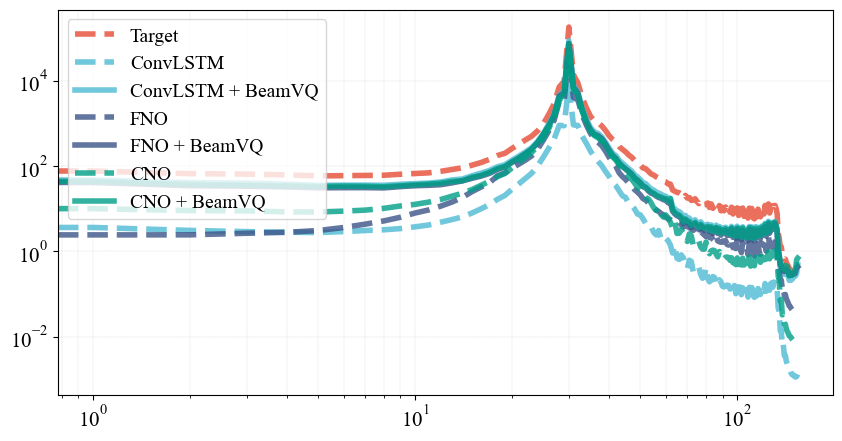

In [34]:
import numpy as np
import matplotlib.pyplot as plt

target = np.load('target.npy')
convlstm = np.load('convlstm_pred.npy')
convlstm_BeamVQ = np.load('convlstm_BeamVP_pred.npy')
fno = np.load('fno_pred.npy')
fno_BeamVQ = np.load('fno_BeamVP_pred.npy')
cno = np.load('cno_pred.npy')
cno_BeamVQ = np.load('cno_BeamVP_pred.npy')

colors = ['#E64B35CC', '#4DBBD5CC', '#3C5488CC', '#00A087CC', '#F39B7FCC', '#8491B4CC']
line_styles = ['--', '-', '--', '-', '--', '-']

plt.rcParams['font.family'] = 'Times New Roman'

# Create a plot figure
fig = plt.figure(figsize=(10, 5))
x_idx = np.arange(155)  
linewidth = 5
def plot_spectrum(data, label, color, linestyle):
    spec_mean, spec_stds = spectrum_band(data)
    plt.plot(x_idx, spec_mean[x_idx], label=label, color=color, linestyle=linestyle, linewidth=4)

# Plotting

plot_spectrum(target, 'Target', colors[0], line_styles[0])
plot_spectrum(convlstm, 'ConvLSTM', colors[1], line_styles[0])
plot_spectrum(convlstm_BeamVQ, 'ConvLSTM + BeamVQ', colors[1], line_styles[1])
plot_spectrum(fno, 'FNO', colors[2], line_styles[0])
plot_spectrum(fno_BeamVQ, 'FNO + BeamVQ', colors[2], line_styles[1])
plot_spectrum(cno, 'CNO', colors[3], line_styles[0])
plot_spectrum(cno_BeamVQ, 'CNO + BeamVQ', colors[3], line_styles[1])

# Adding plot settings
plt.legend(fontsize=14, loc=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")
plt.xscale("log")
# plt.ylabel("Energy Spectrum", size=18)
# plt.xlabel("Wave Number", size=18)
#plt.savefig("spec_ci_all.png", dpi=400, bbox_inches='tight')
plt.grid(True, which='both', linestyle='--', linewidth=0.2, color='gray', alpha=0.5)
plt.show()


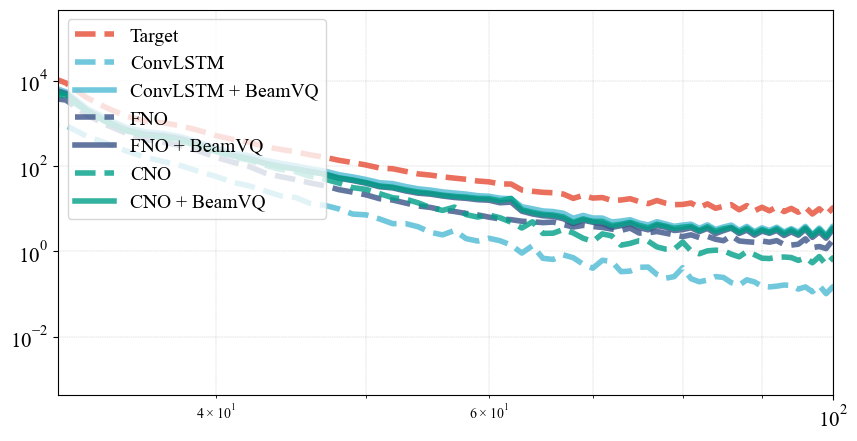

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Load data
target = np.load('target.npy')
convlstm = np.load('convlstm_pred.npy')
convlstm_BeamVQ = np.load('convlstm_BeamVP_pred.npy')
fno = np.load('fno_pred.npy')
fno_BeamVQ = np.load('fno_BeamVP_pred.npy')
cno = np.load('cno_pred.npy')
cno_BeamVQ = np.load('cno_BeamVP_pred.npy')

# Colors and line styles
colors = ['#E64B35CC', '#4DBBD5CC', '#3C5488CC', '#00A087CC', '#F39B7FCC', '#8491B4CC']
line_styles = ['--', '-', '--', '-', '--', '-']

# Setting font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# Create a plot figure
fig = plt.figure(figsize=(10, 5))
x_idx = np.arange(155)  # Assuming the data length is 155, adjust if different

def plot_spectrum(data, label, color, linestyle):
    spec_mean, spec_stds = spectrum_band(data)
    plt.plot(x_idx, spec_mean[x_idx], label=label, color=color, linestyle=linestyle, linewidth=4)

# Plotting
plot_spectrum(target, 'Target', colors[0], line_styles[0])
plot_spectrum(convlstm, 'ConvLSTM', colors[1], line_styles[0])
plot_spectrum(convlstm_BeamVQ, 'ConvLSTM + BeamVQ', colors[1], line_styles[1])
plot_spectrum(fno, 'FNO', colors[2], line_styles[0])
plot_spectrum(fno_BeamVQ, 'FNO + BeamVQ', colors[2], line_styles[1])
plot_spectrum(cno, 'CNO', colors[3], line_styles[0])
plot_spectrum(cno_BeamVQ, 'CNO + BeamVQ', colors[3], line_styles[1])

# Setting the x-axis to focus on 10^1.5 to 10^2
plt.xlim([10**1.5, 10**2])

# Adding plot settings
plt.legend(fontsize=14, loc=2)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yscale("log")
plt.xscale("log")
# plt.ylabel("Energy Spectrum", size=18)
# plt.xlabel("Wave Number", size=18)
#plt.savefig("spec_ci_all.png", dpi=400, bbox_inches='tight')
plt.grid(True, which='both', linestyle='--', linewidth=0.3, color='gray', alpha=0.5)
plt.show()
